In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 900.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46113,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 900.00 GiB
Comm: tcp://127.0.0.1:42859,Total threads: 4
Dashboard: /proxy/44663/status,Memory: 150.00 GiB
Nanny: tcp://127.0.0.1:35887,


# We first make a simple grid from the supergrid

In [6]:
def grid_double_to_simple():
    cinfile = "/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_hgrid_original.nc"
    #cinfile = "/scratch/e14/pc5520/ISF/AMERY/ocean_hgrid_original_10_2.nc"
    ncfile = Dataset(cinfile,'r+')
    #Get vars
    xi = ncfile.variables['x'][:,:]
    yi  = ncfile.variables['y'][:,:]
    areai  = ncfile.variables['area'][:,:]
    ncfile.close()

    ncfile = Dataset("/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_hgrid_simple.nc",'w')
    #Adapt var
    #vx  = ncfile.createVariable('x' , 'float',('nyp', 'nxp'))
    #vy  = ncfile.createVariable('y' , 'float',('nyp', 'nxp'))
    xx    = xi[1::2,1::2]*0
    yy    = yi[1::2,1::2]*0
    areaa = areai[1::2,1::2]*0
    xx[:,:]    = xi[1::2,1::2]
    yy[:,:]    = yi[1::2,1::2]
    areaa[:,:] = areai[1::2,1::2]
    #xx = xx[:-1,:-1]
    #yy = yy[:-1,:-1]
    nyp,nxp = xx.shape[0],xx.shape[1]
    ncfile.createDimension('nxp', nxp)
    ncfile.createDimension('nyp', nyp)
    x = ncfile.createVariable('x', 'float', ('nyp', 'nxp'))
    y = ncfile.createVariable('y', 'float', ('nyp', 'nxp'))
    area = ncfile.createVariable('area', 'float', ('nyp', 'nxp'))

    x[:,:] = xx[:,:]
    y[:,:] = yy[:,:]
    area[:,:] = areaa[:,:]
    ncfile.close()

In [7]:
grid_double_to_simple()

# We then interpolate BedMachine into the simple grid

In [3]:
import numpy as np
from netCDF4 import Dataset as nc

In [5]:
di = xr.open_dataset("/g/data/e14/pc5520/ISF/BATHY/BedMachineAntarctica-v3_NEMOBAT.nc")

In [6]:
#hgrid_path = "/g/data/e14/pc5520/forcing_files/ICB/ocean_hgrid_simple.nc" #global
hgrid_path = "/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_hgrid_simple.nc" #panan

dg = xr.open_dataset(hgrid_path)[["x", "y"]]
dg = dg.rename({"x": "lon", "y": "lat"}).set_coords(["lon", "lat"])

In [7]:
regridder = xe.Regridder(di, dg, "bilinear")

In [8]:
data_regrided = regridder(di)

In [9]:
data_regrided

<xarray.Dataset>
Dimensions:    (nyp: 845, nxp: 3600)
Coordinates:
    lat        (nyp, nxp) float64 -81.11 -81.11 -81.11 ... -37.14 -37.14 -37.14
    lon        (nyp, nxp) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Dimensions without coordinates: nyp, nxp
Data variables: (12/13)
    mask       (nyp, nxp) int8 2 2 2 1 2 2 2 2 2 1 2 2 ... 0 0 0 0 0 0 0 0 0 0 0
    firn       (nyp, nxp) float32 37.24 37.23 37.22 37.21 ... 0.0 0.0 0.0 0.0
    surface    (nyp, nxp) float32 3.967e+03 3.966e+03 3.961e+03 ... 0.0 0.0 0.0
    thickness  (nyp, nxp) float32 2.967e+03 2.835e+03 2.731e+03 ... 0.0 0.0 0.0
    bed        (nyp, nxp) float32 1.001e+03 1.13e+03 1.23e+03 ... 0.0 0.0 0.0
    errbed     (nyp, nxp) float32 31.88 38.05 34.68 33.98 ... 0.0 0.0 0.0 0.0
    ...         ...
    dataid     (nyp, nxp) int8 0 0 0 0 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0 0
    geoid      (nyp, nxp) int16 1 1 1 0 1 1 1 1 1 0 1 ... 0 0 0 0 0 0 0 0 0 0 0
    thick      (nyp, nxp) float64 2.967e+03 2.835e+03 2.731e+03 ... 0.0 0.0 0.0
    isfd       (nyp, nxp) float64 1.001e+03 1.13e+03 1.23e+03 ... 0.0 0.0 0.0
    test       (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    msk_oce    (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

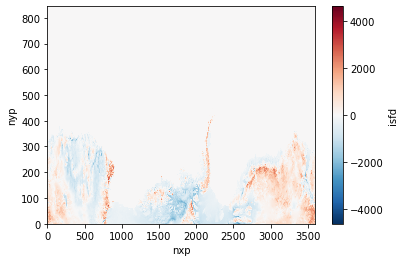

In [10]:
data_regrided.isfd.plot()

In [11]:
isfd = data_regrided.isfd.load()
surf = data_regrided.surface.load()
thick = data_regrided.thickness.load()
bed = data_regrided.bed.load()
msk = data_regrided.msk_oce.load()

## We then smooth the values with a Shapiro filter

In [ ]:
def shapiro_filter(varname=None,nb_passes=2):
    order = 2
    weight = 0.6
    varname1 = varname
    npy,npx = varname1.shape[0],varname1.shape[1]
    tmp = varname1 * 0 
    tmp2 = varname1 * 0
    # y direction 
    # Do the first y pass to initialize the temporary array
    for ji in tqdm(range(0,npx)):
        for jj in range(0+1,npy-1):
            aa = varname1[jj-1,ji]
            bb = varname1[jj+1,ji]
            if aa = 0: aa = varname1[jj,ji]
            if bb = 0: bb = varname1[jj,ji]
            tmp[jj,ji] = 0.25 * (aa + bb - 2*varname1[jj,ji])
            
    # Other passes in the y direction
    for ji in tqdm(range(0,npx)):
        for jj in range(0+1,npy-1):
            aa = tmp[jj-1,ji]
            bb = tmp[jj+1,ji]
            if aa = 0: aa = tmp[jj,ji]
            if bb = 0: bb = tmp[jj,ji]
            tmp2[jj,ji] = - 0.25 * (aa + bb - 2*tmp[jj,ji])
            

In [12]:
from netCDF4 import Dataset as nc
import numpy.ma as ma

In [13]:
ncfile = nc('/g/data/e14/pc5520/ISF/BATHY_m100/xe_regrid_isfd_panan.nc','w')
nyp = data_regrided.nyp
nxp = data_regrided.nxp
dnyp = ncfile.createDimension('nyp', nyp.shape[0])
dnxp = ncfile.createDimension('nxp', nxp.shape[0])
visfd = ncfile.createVariable('isf_draft', 'float',('nyp', 'nxp'))
vsurf = ncfile.createVariable('surf', 'float',('nyp', 'nxp'))
vthick = ncfile.createVariable('thick', 'float',('nyp', 'nxp'))
vbed = ncfile.createVariable('Bathymetry', 'float',('nyp', 'nxp'))
vmsk = ncfile.createVariable('msk', 'float',('nyp', 'nxp'))
visfd[:,:] = isfd
vsurf[:,:] = surf
vthick[:,:] = thick
vbed[:,:] = bed
vmsk[:,:] = msk
ncfile.close()

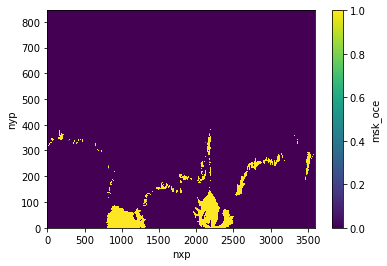

In [14]:
msk.plot()

# Once this was finished we need to run the following commands on the terminal

In [ ]:
#We first build the msk
#ncap2 -O -s 'where ( isf_draft > 0.0 ) msk = 0 ; where ( Bathymetry > 0.0 ) msk = 0' xe_regrid_isfd_panan.nc xe_regrid_isfd_panan_2.nc

#We then apply it
#ncap2 -O -s 'isf_draft = isf_draft * msk ; thick = thick * msk ; Bathymetry = Bathymetry * msk ; isf_draft = - isf_draft ; Bathymetry = - Bathymetry' xe_regrid_isfd_panan_2.nc xe_regrid_isfd_panan_3.nc

# Finally, we drown IC to fill the IC below the shelves

In [1]:
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import os
from tqdm import tqdm
from time import sleep

In [2]:
def extendinit():
    #ncfile="/scratch/e14/pc5520/ISF/AMERY/scripts/init_TS.nc"
    ncfile="/g/data/e14/pc5520/inputs/mom6/panan-01/forcing/temp_salt_init_z.nc"
    ncfile = Dataset(ncfile,'r+')
    temp = ncfile.variables['temp']
    salt = ncfile.variables['salt']
    temp2 = ncfile.variables['temp'][:,:,:]
    salt2 = ncfile.variables['salt'][:,:,:]
    npz,npy,npx = temp2.shape[0],temp2.shape[1],temp2.shape[2]
    npy = 520 #panan
    vertical = "no"
    horizontal = "yes"
    if vertical == "yes":
        for ji in range(0,npx):
            for jj in range(0,npy):
                for jk in range(1,npz):
                    if  np.ma.is_masked(temp2[jk,jj,ji]):
                        temp2[jk,jj,ji] = temp2[jk-1,jj,ji]
                        salt2[jk,jj,ji] = salt2[jk-1,jj,ji]
    if horizontal == "yes":
        for ji in tqdm(range(0,npx)):
            sleep(0.01)
            for jj in range(npy-2,-1,-1):
                for jk in range(0,npz):
                    if  np.ma.is_masked(temp2[jk,jj,ji]):
                        temp2[jk,jj,ji] = temp2[jk,jj+1,ji]
                        salt2[jk,jj,ji] = salt2[jk,jj+1,ji]
    temp[:,:,:] = temp2[:,:,:]
    salt[:,:,:] = salt2[:,:,:]
    ncfile.close()


In [3]:
extendinit()

100%|██████████| 3600/3600 [11:10<00:00,  5.37it/s]


# Put topo values in the ice-shelves

In [3]:
import numpy as np
from netCDF4 import Dataset as nc
from tqdm import tqdm
from netCDF4 import Dataset

In [7]:
ncfile_topo = "/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_topog.nc"
ncfile_topo = Dataset(ncfile_topo,'r+')
bathy_orig = ncfile_topo.variables['depth']
bathy_orig_val = ncfile_topo.variables['depth'][:,:]
bathy_new = bathy_orig_val * 0

ncfile_shelf = "/g/data/e14/pc5520/inputs/mom6/panan-01/forcing/xe_regrid_isfd_panan_3.nc"
ncfile_shelf = Dataset(ncfile_shelf,'r+')
bathy_shelf = ncfile_shelf.variables['Bathymetry'][:,:]

npy,npx = bathy_shelf.shape[0],bathy_shelf.shape[1]

zmin = 1000
zmax = 2000

for ji in tqdm(range(0,npx)):
    for jj in range(0,npy):
        if np.ma.is_masked(bathy_orig_val[jj,ji]) == True and bathy_shelf[jj,ji] > 0:
            bathy_new[jj,ji] = bathy_shelf[jj,ji]
        else:
            if bathy_shelf[jj,ji] ==  0:
                bathy_new[jj,ji] = bathy_orig_val[jj,ji]
            elif bathy_shelf[jj,ji] <=  zmin:
                bathy_new[jj,ji] = bathy_shelf[jj,ji]
            elif (bathy_shelf[jj,ji] >=  zmin) and (bathy_shelf[jj,ji] <=  zmax):
                zeps = (bathy_shelf[jj,ji]-zmin)/(zmax-zmin)
                bathy_new[jj,ji]=bathy_shelf[jj,ji]*(1-zeps)+bathy_orig_val[jj,ji]*zeps

bathy_orig[:,:] = bathy_new[:,:]
ncfile_shelf.close()
ncfile_topo.close()

100%|██████████| 3600/3600 [00:18<00:00, 199.01it/s]


#  Control diff between shelves and bathy

In [4]:
ncfile_topo = "/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_topog.nc"
ncfile_topo = Dataset(ncfile_topo,'r+')
ncfile_shelf = "/g/data/e14/pc5520/inputs/mom6/panan-01/forcing/xe_regrid_isfd_panan_3.nc"
ncfile_shelf = Dataset(ncfile_shelf,'r+')

bathy_orig = ncfile_topo.variables['depth'][:,:]
isf_draft = ncfile_shelf.variables['isf_draft']
isf_draft_val = ncfile_shelf.variables['isf_draft'][:,:]
surf = ncfile_shelf.variables['surf'][:,:]
thick = ncfile_shelf.variables['thick']
thick_val = ncfile_shelf.variables['thick'][:,:]

npy,npx = isf_draft.shape[0],isf_draft.shape[1]

diff = 50 #minimum distance between shelf and bathy

for ji in tqdm(range(0,npx)):
    for jj in range(0,npy):
        if isf_draft[jj,ji] > 0 and (bathy_orig[jj,ji] - isf_draft[jj,ji]) < diff:
            isf_draft_val[jj,ji] = max(10,isf_draft[jj,ji]-diff)
            thick_val[jj,ji] = isf_draft_val[jj,ji] + surf[jj,ji]

isf_draft[:,:] = isf_draft_val[:,:]
thick[:,:] = thick_val[:,:]

ncfile_shelf.close()
ncfile_topo.close()

100%|██████████| 3600/3600 [09:46<00:00,  6.14it/s]


# Add area values

In [5]:
ncfile_hgrid = "/g/data/e14/pc5520/inputs/mom6/panan-01/ocean_hgrid_simple.nc"
ncfile_hgrid = Dataset(ncfile_hgrid,'r+')

ncfile_shelf = "/g/data/e14/pc5520/inputs/mom6/panan-01/forcing/xe_regrid_isfd_panan_3.nc"
ncfile_shelf = Dataset(ncfile_shelf,'r+')

area = ncfile_hgrid.variables['area'][:,:]
msk = ncfile_shelf.variables['msk'][:,:]
npy,npx = msk.shape[0],msk.shape[1]

varea_shelf_h = ncfile_shelf.createVariable('area_shelf_h', 'float',('nyp', 'nxp'))

varea_shelf_h[:,:] = area[:,:] * msk[:,:]

ncfile_hgrid.close()
ncfile_shelf.close()